# Custom datasets

How to get your own data in PyTorch...

In [1]:
import torch
from torch import nn
from torchinfo import summary
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import requests
import zipfile
import pathlib
from pathlib import Path
import os
import random
from PIL import Image
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from typing import Tuple, Dict, List
from timeit import default_timer as timer

torch.__version__

/home/hamid-tuf/miniconda3/envs/dl_env/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/hamid-tuf/miniconda3/envs/dl_env/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/home/hamid-tuf/miniconda3/envs/dl_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'2.6.0'

## Device-agnostic code

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [3]:
!nvidia-smi

Sun Dec  7 15:16:49 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.95.05              Driver Version: 580.95.05      CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4070 ...    Off |   00000000:01:00.0  On |                  N/A |
| N/A   44C    P8              4W /   55W |      65MiB /   8188MiB |     35%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# 1. Get & prepare data

Starting with a subset of `Food101` dataset.

In [4]:
data_path = Path("../data/")
image_path = data_path / "pizza_steak_sushi"

if image_path.is_dir():
    print(f"{image_path} directory exists")
else:
    print(f"{image_path} directory does not exist, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

../data/pizza_steak_sushi directory exists


In [5]:
# Download pizza, steak, sushi data
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
    print("downloading pizza, steak, sushi data ...")
    url_to_dataset = "https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip"
    request = requests.get (url_to_dataset)
    f.write(request.content)

with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
    print("unzipping pizza, steak, sushi data ...")
    zip_ref.extractall(image_path)


downloading pizza, steak, sushi data ...
unzipping pizza, steak, sushi data ...


## Data preparation and exploration

In [6]:
def walk_through_dir(dir_path):
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

walk_through_dir(image_path)

There are 2 directories and 0 images in '../data/pizza_steak_sushi'.
There are 3 directories and 0 images in '../data/pizza_steak_sushi/train'.
There are 0 directories and 72 images in '../data/pizza_steak_sushi/train/sushi'.
There are 0 directories and 78 images in '../data/pizza_steak_sushi/train/pizza'.
There are 0 directories and 75 images in '../data/pizza_steak_sushi/train/steak'.
There are 3 directories and 0 images in '../data/pizza_steak_sushi/test'.
There are 0 directories and 31 images in '../data/pizza_steak_sushi/test/sushi'.
There are 0 directories and 25 images in '../data/pizza_steak_sushi/test/pizza'.
There are 0 directories and 19 images in '../data/pizza_steak_sushi/test/steak'.


In [7]:
train_dir = image_path / "train"
test_dir = image_path / "test"

# Walk through training directory
walk_through_dir(train_dir)



There are 3 directories and 0 images in '../data/pizza_steak_sushi/train'.
There are 0 directories and 72 images in '../data/pizza_steak_sushi/train/sushi'.
There are 0 directories and 78 images in '../data/pizza_steak_sushi/train/pizza'.
There are 0 directories and 75 images in '../data/pizza_steak_sushi/train/steak'.


## Visualizing an image

[PosixPath('../data/pizza_steak_sushi/train/sushi/1552504.jpg'), PosixPath('../data/pizza_steak_sushi/train/sushi/1575445.jpg'), PosixPath('../data/pizza_steak_sushi/train/sushi/2574453.jpg'), PosixPath('../data/pizza_steak_sushi/train/sushi/700405.jpg'), PosixPath('../data/pizza_steak_sushi/train/sushi/307738.jpg'), PosixPath('../data/pizza_steak_sushi/train/sushi/748830.jpg'), PosixPath('../data/pizza_steak_sushi/train/sushi/765684.jpg'), PosixPath('../data/pizza_steak_sushi/train/sushi/2175561.jpg'), PosixPath('../data/pizza_steak_sushi/train/sushi/2021381.jpg'), PosixPath('../data/pizza_steak_sushi/train/sushi/794647.jpg'), PosixPath('../data/pizza_steak_sushi/train/sushi/2004525.jpg'), PosixPath('../data/pizza_steak_sushi/train/sushi/710379.jpg'), PosixPath('../data/pizza_steak_sushi/train/sushi/2267190.jpg'), PosixPath('../data/pizza_steak_sushi/train/sushi/2813454.jpg'), PosixPath('../data/pizza_steak_sushi/train/sushi/2641778.jpg'), PosixPath('../data/pizza_steak_sushi/train/su

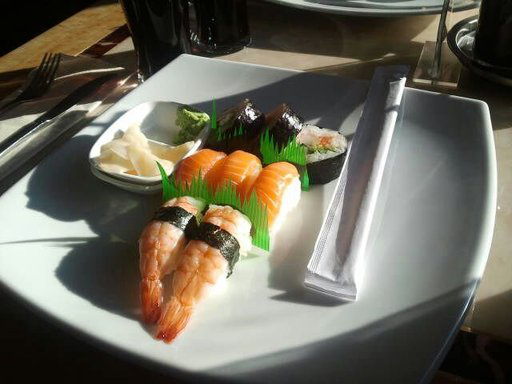

In [8]:
# random.seed(42)  # reproducibility

# 1. First getting all the images paths:
image_path_list = list(image_path.glob("*/*/*.jpg"))
print(image_path_list)
print(len(image_path_list),"\n")

# 2. Pick a random image path:
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name:
image_class = random_image_path.parent.stem
print(random_image_path)
print(random_image_path.parent)
print(random_image_path.parent.stem, "\n")

# 4. Open image:
img = Image.open(random_image_path)

# 5. Print image metadata:
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

## Using `matplotlib` to show images

[[[ 4  4  2]
  [ 4  4  2]
  [ 4  4  2]
  ...
  [17 18 13]
  [12 13  8]
  [ 7  8  3]]

 [[ 4  4  2]
  [ 4  4  2]
  [ 4  4  2]
  ...
  [16 17 12]
  [13 14  9]
  [ 9 10  5]]

 [[ 3  3  1]
  [ 3  3  1]
  [ 3  3  1]
  ...
  [14 15 10]
  [13 14  9]
  [11 12  7]]

 ...

 [[12  9  4]
  [11  8  3]
  [11  8  3]
  ...
  [ 1  6  0]
  [ 1  6  0]
  [ 0  6  0]]

 [[12  9  4]
  [11  8  3]
  [11  8  3]
  ...
  [ 1  6  0]
  [ 1  6  0]
  [ 0  6  0]]

 [[12  9  4]
  [11  8  3]
  [11  8  3]
  ...
  [ 1  6  0]
  [ 1  6  0]
  [ 0  7  0]]]


(-0.5, 511.5, 383.5, -0.5)

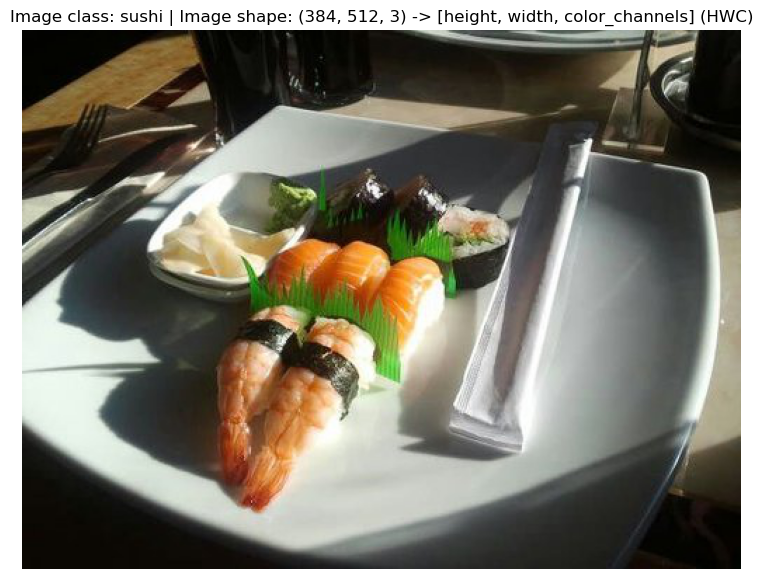

In [9]:
img_as_array = np.asarray(img)
print(img_as_array)

plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels] (HWC)")
plt.axis(False)

## Transferring data to PyTorch data structure (tensor)

Turning data into a `torch.utils.data.Dataset` and subsequently a `torch.data.Dataloader`.
This makes the dataset to be compatible with our PyTorch model.

In [10]:
data_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),  # Resizing the image
    transforms.RandomHorizontalFlip(p=0.5),  # Flip the image randomly on the horizontal-data augmentation; artificially increasing diversity of the dataset.
    transforms.ToTensor()  # Turn the image to torch.Tensor
])

In [11]:
data_transform(img)

tensor([[[0.0118, 0.0078, 0.0078,  ..., 0.0431, 0.0353, 0.0431],
         [0.0078, 0.0078, 0.0118,  ..., 0.0314, 0.0314, 0.0431],
         [0.0078, 0.0118, 0.0118,  ..., 0.0275, 0.0314, 0.0431],
         ...,
         [0.0431, 0.0431, 0.0431,  ..., 0.0392, 0.0471, 0.0235],
         [0.0431, 0.0431, 0.0431,  ..., 0.0275, 0.0471, 0.0196],
         [0.0431, 0.0392, 0.0431,  ..., 0.0157, 0.0392, 0.0157]],

        [[0.0118, 0.0078, 0.0078,  ..., 0.0431, 0.0392, 0.0471],
         [0.0078, 0.0078, 0.0118,  ..., 0.0353, 0.0353, 0.0471],
         [0.0078, 0.0118, 0.0157,  ..., 0.0314, 0.0353, 0.0471],
         ...,
         [0.0314, 0.0314, 0.0314,  ..., 0.0275, 0.0314, 0.0157],
         [0.0314, 0.0314, 0.0314,  ..., 0.0196, 0.0353, 0.0157],
         [0.0314, 0.0275, 0.0314,  ..., 0.0157, 0.0275, 0.0196]],

        [[0.0039, 0.0000, 0.0039,  ..., 0.0275, 0.0196, 0.0275],
         [0.0000, 0.0000, 0.0000,  ..., 0.0196, 0.0196, 0.0275],
         [0.0000, 0.0039, 0.0000,  ..., 0.0157, 0.0157, 0.

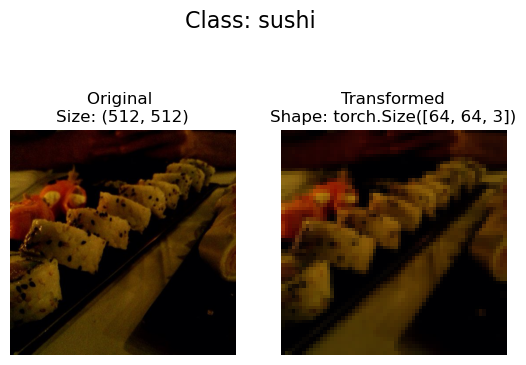

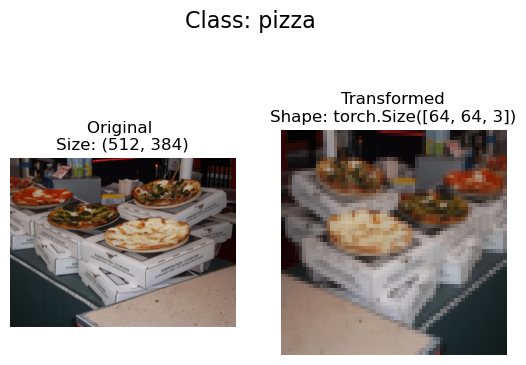

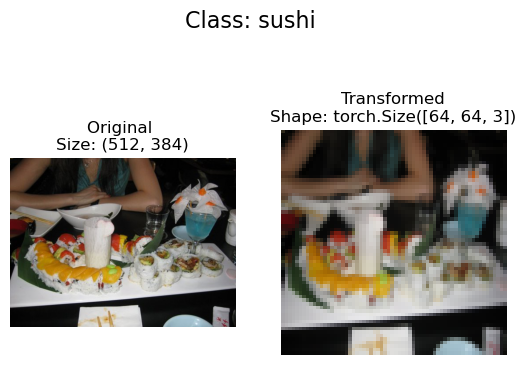

In [12]:
def plot_transformed_images(image_path, transform, n=3, seed=42):
    if seed:
        random.seed(seed)

    random_image_paths = random.sample(image_path, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(nrows=1, ncols=2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis(False)

            # Transform and plot target image
            transformed_image = transform(f).permute(1, 2, 0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_path=image_path_list,
                        transform=data_transform,
                        seed=None)

## Loading image data using `ImageFolder`

In [13]:
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform,
                                  target_transform=None)

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: ../data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: ../data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [14]:
train_data[0]

(tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
          [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
          [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
          ...,
          [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
          [0.0863, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
          [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],
 
         [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
          [0.0706, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
          [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
          ...,
          [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
          [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
          [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],
 
         [[0.0941, 0.0902, 0.0902,  ..., 0.0196, 0.0196, 0.0196],
          [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
          [0.0902, 0.0902, 0.0902,  ...,

In [15]:
os.cpu_count()

20

## Turn dataset (loaded images) into `DataLoader`s

Data loaders help us to turn our dataset's into iterables and we can customise the bach_size, so the model can see baches of images at a time.

In [16]:
## Turn train and test datasets into DataLoader's
BATCH_SIZE = 1

train_dataloader = DataLoader(dataset=train_data,
                                   batch_size=BATCH_SIZE,
                                   num_workers=1,
                                   shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                                   batch_size=BATCH_SIZE,
                                   num_workers=1,
                                   shuffle=False)

print(train_dataloader, "\n", test_dataloader, "\n")
print(len(train_dataloader), len(test_dataloader))


225 75


## Loading image data with a custom `Dataset`

1. Want to be able to load images from file.
2. Want to be able to get class names from Dataset.
3. Want to be able to get classes as dictionary from the Dataset.

Pros:
* Can create a Dataset out of almost anything
* Not limited to PyTorch pre-built `Dataset` functions

Cons:
* Even though you could create `Dataset` out of almost naything, <u>it does not mean it will work</u>.
* Using a custom `Dataset` often results in us wrintine more code, which could be <u>prone to errors</u> or <u>preformance issues</u>.

In [17]:
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

## Creating a hellper function to get class names

In [18]:
# Setup path for target directory:
target_directory = train_dir
print(f"Target dir: {target_directory}")

# Get the class names from target directory
class_names = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names

Target dir: ../data/pizza_steak_sushi/train


['pizza', 'steak', 'sushi']

In [19]:
list(os.scandir(target_directory))

[<DirEntry 'sushi'>, <DirEntry 'pizza'>, <DirEntry 'steak'>]

In [20]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    # 1. Get the class names by scanning the target directory
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

    # 2. Raise an error if class names could not be found
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory} ... please check file structure.")

    # 3. Create a dictionary of index labels (computers prefer numbers rather than strings as labels)
    class_to_idx = {class_name: i for i, class_name in enumerate(classes)}
    return classes, class_to_idx

In [21]:
find_classes(train_dir)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

## Create a custom `DataSet` to replicate `ImageFolder`

1. Subclass `torch.utils.data.Dataset`
2. Init our subclass with a target directory (the directory we'd like to get data from) as well as a transform if we'd like to transform our data.
3. Create several attributes:
    * paths - paths of our images
    * transform - the transform we'd like to use
    * classes - a list of the target classes
    * class_to_idx - a dict of the target classes mapped ot integer labels

4. Create a function to `load_images()`, this function will open an image.
5. Overwrite the `__len()__` method to return the length of our dataset.
6. Overwrite the `__getitem()__` method to return a given sample when passed an index.

In [22]:
# 1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):
    # 2. Initialize our custom datasest
    def __init__(self,
                 targ_dir: str,
                 transform=None):
        # 3. Create class attributes
        self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))  # Get all the image paths
        self.transform = transform  # Setup transform
        self.classes, self.class_to_idx = find_classes(targ_dir)  # Create classes and class_to_idx attributes

    # 4. Create a function to load images
    def load_image(self, index: int) -> Image.Image:
        image_path = self.paths[index]
        return Image.open(image_path)

    # 5. Overwrite __len__() 
    def __len__(self) -> int:
        return len(self.paths)

    # 6. Overwrite __getitem__() method to return a particular sample
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        img = self.load_image(index)
        class_name = self.paths[index].parent.name
        class_idx = self.class_to_idx[class_name]

        # Transform if necessary:
        if self.transform:
            return self.transform(img), class_idx  # Return data, label (X, y)
        else:
            return img, class_idx  # Return untransformed image and label


In [23]:
img, label = train_data[200]
img, label

(tensor([[[0.0118, 0.0118, 0.0118,  ..., 0.1294, 0.2039, 0.2196],
          [0.0078, 0.0118, 0.0118,  ..., 0.1725, 0.1961, 0.2196],
          [0.0078, 0.0078, 0.0078,  ..., 0.2392, 0.1843, 0.1843],
          ...,
          [0.8941, 0.9176, 0.9373,  ..., 0.8902, 0.8784, 0.8706],
          [0.8902, 0.9098, 0.9255,  ..., 0.8824, 0.8745, 0.8627],
          [0.8824, 0.8941, 0.9098,  ..., 0.8784, 0.8667, 0.8549]],
 
         [[0.0118, 0.0118, 0.0118,  ..., 0.1137, 0.1725, 0.1882],
          [0.0078, 0.0118, 0.0118,  ..., 0.1294, 0.1725, 0.1961],
          [0.0078, 0.0078, 0.0078,  ..., 0.1882, 0.1490, 0.1647],
          ...,
          [0.8627, 0.8824, 0.9059,  ..., 0.8431, 0.8314, 0.8235],
          [0.8510, 0.8667, 0.8863,  ..., 0.8431, 0.8314, 0.8235],
          [0.8510, 0.8588, 0.8706,  ..., 0.8392, 0.8275, 0.8157]],
 
         [[0.0196, 0.0196, 0.0196,  ..., 0.1176, 0.1765, 0.1882],
          [0.0157, 0.0196, 0.0196,  ..., 0.1255, 0.1725, 0.2000],
          [0.0157, 0.0157, 0.0157,  ...,

In [24]:
## Create a transform
train_transform = transforms.Compose([transforms.Resize(size=(64, 64)),
                                      transforms.RandomHorizontalFlip(p=0.5),
                                      transforms.ToTensor()])

test_transform = transforms.Compose([transforms.Resize(size=(64, 64)),
                                     transforms.ToTensor()])

In [25]:
## Test out our custom dataloader:
train_data_custom = ImageFolderCustom(targ_dir=train_dir,
                                      transform=train_transform)

test_data_custom = ImageFolderCustom(targ_dir=test_dir,
                                     transform=test_transform)

In [26]:
len(train_data), len(train_data_custom)

(225, 225)

In [27]:
train_data_custom.classes

['pizza', 'steak', 'sushi']

In [28]:
print(train_data_custom.classes==train_data.classes)
print(test_data_custom.classes==test_data.classes)

True
True


## Visualize, visualize, visualize
## Create a function to take in a dataset

1. Take in a `Dataset` and a number of other parameters such as class names and how many images to visualize.
2. To prevent the display getting out of hand, let's cap the number of the images to see at 10.
3. Set the random seed for <u>reproducibility</u>.
4. Get a list of random sample indexes from the target dataset.
5. Setup a matplotlib plot
6. Loop through the random sample images and plot them with matplotlib
7. Make sure the dimensions of our images line up with matplotlib (HWC)


In [29]:
# 1. Create a function to take in a dataset
def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: List[str]=None,
                          n: int=10,
                          display_shape: bool=True,
                          seed: int=None):

    # 2. Adjust display if n is too high
    if n>10:
        n=10
        display_shape = False
        print(f"For display, purposes, n shouldn't be larger than 10, setting to 10")

    # 3. Set the seed
    if seed:
        random.seed(seed)

    # 4. Get random sample indexes
    random_samples_idx = random.sample(range(len(dataset)), k=n)

    # 5. Setup plot
    plt.figure(figsize=(16, 8))

    # 6. Loop through random indexes and plot them with matplotlib
    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        # 7. Adjust tensor dimensions for plotting:
        targ_image_adjust = targ_image.permute(1, 2, 0)  # [color_channels, height, width] -> [height, width, color_channels]

        # plot adjusted samples
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis("off")
        if classes:
            title = f"Class: {classes[targ_label]}"
            if display_shape:
                title = title + f"\nshape: {targ_image_adjust.shape}"
            plt.title(title, y=1.15)  # Move title up to avoid overlap
        else:
            plt.title("")

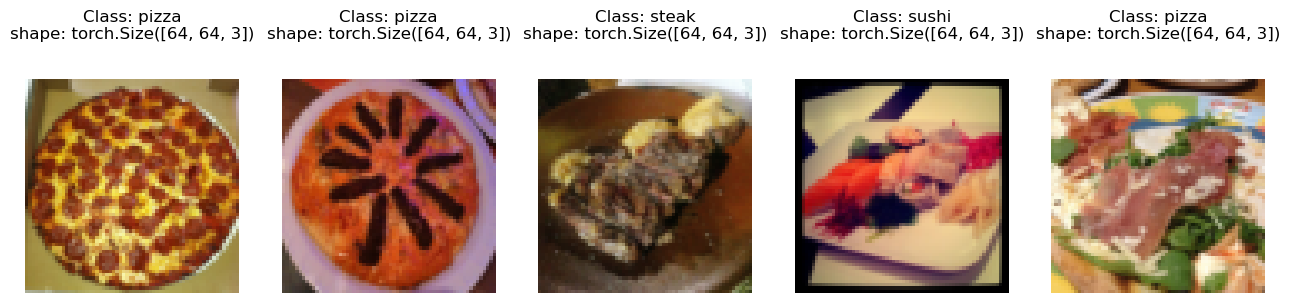

In [30]:
display_random_images(train_data, 
                      n=5,
                      classes=class_names,
                      seed=None)

## Turn custom loaded datasets into `DataLoader`

In [31]:
BATCH_SIZE = 64
NUM_WORKERS = os.cpu_count()

train_dataloader_custom = DataLoader(dataset=train_data_custom,
                                          batch_size=BATCH_SIZE,
                                          num_workers=NUM_WORKERS,
                                          shuffle=True)

test_dataloader_custom = DataLoader(dataset=test_data_custom,
                                          batch_size=BATCH_SIZE,
                                          num_workers=NUM_WORKERS,
                                          shuffle=False)

train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x7ab2d5077f70>,
 <torch.utils.data.dataloader.DataLoader at 0x7ab2d50775e0>)

In [32]:
# Get image and label from custom dataloader
img_custom, label_custom = next(iter(train_dataloader_custom))

# Print out the shapes
img_custom.shape, label_custom.shape

(torch.Size([64, 3, 64, 64]), torch.Size([64]))

## Other forms of data transformation (image) - Data Augmentation

Data augmentation: process of <u>artificially</u> adding diversity to training data.

In the case of image data, this may mean <u>applying various image transformations</u> to the traing images.

In [33]:
train_transform = transforms.Compose([transforms.Resize(size=(224, 224)),
                                      transforms.TrivialAugmentWide(num_magnitude_bins=31),
                                      transforms.ToTensor()])

test_transform = transforms.Compose([transforms.Resize(size=(224, 224)),
                                     transforms.ToTensor()])

In [34]:
image_path

PosixPath('../data/pizza_steak_sushi')

In [35]:
# Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))
image_path_list[:10]

[PosixPath('../data/pizza_steak_sushi/train/sushi/1552504.jpg'),
 PosixPath('../data/pizza_steak_sushi/train/sushi/1575445.jpg'),
 PosixPath('../data/pizza_steak_sushi/train/sushi/2574453.jpg'),
 PosixPath('../data/pizza_steak_sushi/train/sushi/700405.jpg'),
 PosixPath('../data/pizza_steak_sushi/train/sushi/307738.jpg'),
 PosixPath('../data/pizza_steak_sushi/train/sushi/748830.jpg'),
 PosixPath('../data/pizza_steak_sushi/train/sushi/765684.jpg'),
 PosixPath('../data/pizza_steak_sushi/train/sushi/2175561.jpg'),
 PosixPath('../data/pizza_steak_sushi/train/sushi/2021381.jpg'),
 PosixPath('../data/pizza_steak_sushi/train/sushi/794647.jpg')]

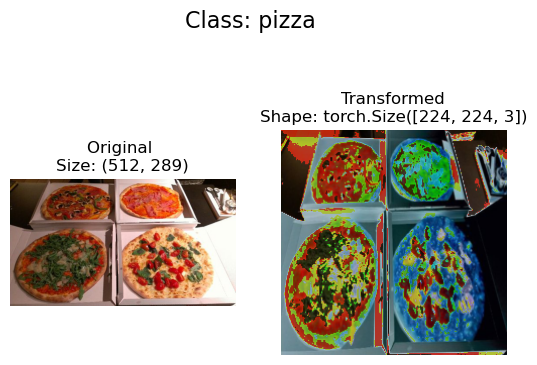

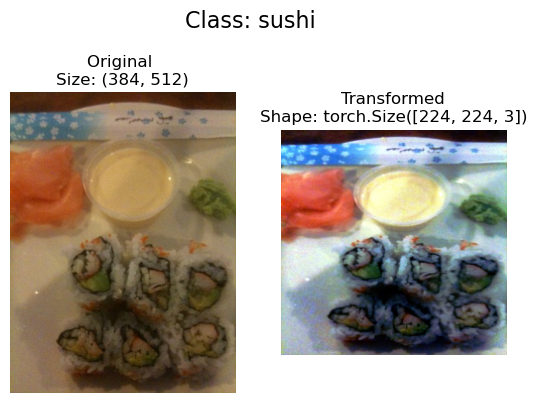

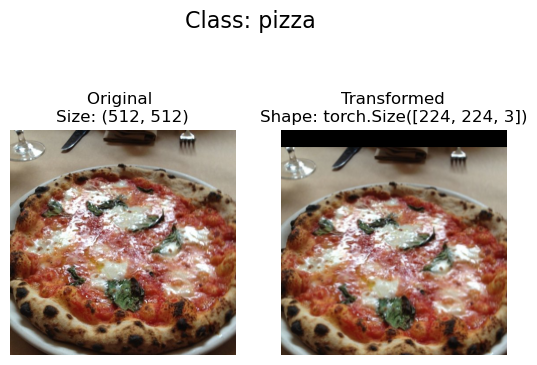

In [36]:
plot_transformed_images(image_path=image_path_list,
                        transform=train_transform,
                        n=3,
                        seed=None)

# 2. Build a Model

Replicating `TinyVGG` architecture from the CNN Explainer.

## Creating transforms and loading data for Model 0

In [37]:
# 1. Create a simple tranform
simple_transform = transforms.Compose([transforms.Resize(size=(64, 64)),
                                        transforms.ToTensor()])

# 2. Load and transform data:
train_data_simple = datasets.ImageFolder(root=train_dir,
                                         transform=simple_transform)
test_data_simple = datasets.ImageFolder(root=test_dir,
                                        transform=simple_transform)

# 3. Turn datasets into DataLoaders:
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dataloader_simple = DataLoader(dataset=train_data_simple,
                                          batch_size=BATCH_SIZE,
                                          shuffle=True,
                                          num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                         batch_size=BATCH_SIZE,
                                         shuffle=False,
                                         num_workers=NUM_WORKERS)

In [38]:
class TinyVGG(nn.Module):
    """
    Model architecture copying / replicating TinyVGG from CNN Explainer: https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self,
                 input_shape: int,
                 hidden_units: int,
                 output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units * 13 * 13,
            out_features=output_shape)
        )

    def forward(self, x):
        x = self.conv_block_1(x)
        # print(x.shape)
        x = self.conv_block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)

        return x

In [39]:
torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(class_names)).to(device)

model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

### Check the model with a dummy forward pass if the forward pass is working correctly or not.

In [40]:
image_batch, label_batch = next(iter(train_dataloader_simple))
image_batch.shape, label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [41]:
model_0(image_batch.to(device))

tensor([[ 2.0789e-02, -1.9350e-03,  9.5317e-03],
        [ 1.8427e-02,  2.4670e-03,  6.6757e-03],
        [ 1.7699e-02,  1.0262e-03,  9.4657e-03],
        [ 2.4441e-02, -3.3526e-03,  9.6011e-03],
        [ 1.9930e-02,  6.6317e-04,  1.0779e-02],
        [ 2.1281e-02,  2.0433e-03,  5.0046e-03],
        [ 2.0999e-02,  1.2872e-04,  1.2473e-02],
        [ 2.1577e-02, -1.9507e-03,  9.6941e-03],
        [ 2.4504e-02, -4.7745e-03,  8.5280e-03],
        [ 2.0252e-02, -4.7297e-04,  1.0908e-02],
        [ 2.2215e-02, -4.1837e-04,  9.8123e-03],
        [ 2.2313e-02, -2.1621e-03,  9.4455e-03],
        [ 2.1841e-02, -3.7132e-03,  8.3782e-03],
        [ 2.2863e-02, -1.7723e-03,  1.0287e-02],
        [ 2.1647e-02, -4.4139e-03,  9.5022e-03],
        [ 2.2096e-02, -4.1425e-03,  9.3853e-03],
        [ 2.1209e-02, -4.4219e-03,  1.1475e-02],
        [ 2.1711e-02, -2.7657e-03,  8.5006e-03],
        [ 1.9951e-02,  2.8301e-05,  8.4380e-03],
        [ 1.8298e-02,  1.6307e-03,  8.5499e-03],
        [ 2.0768e-02

### Using `torchinfo` to get an idea of shapes going through our model

In [42]:
summary(model_0, input_size=[1, 3, 64, 64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

# 3. Train and Test

* train_step() - Takes in a model and dataloader and trains the model on the dataloader.
* test_step() - Takes in a model and dataloader and evaluates the model on the dataloader.

In [ ]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device=device):

    model.train()

    train_loss, train_acc = 0, 0

    for batch, (x, y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device)

        y_pred = model(x)

        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        # Claculate accuracy metric
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class==y).sum().item() / len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc



In [44]:
# Create a test step
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device=device):
    
    model.eval()

    test_loss, test_acc = 0, 0

    # Turn on inference mode:
    with torch.inference_mode():
        for batch, (x, y) in enumerate(dataloader):
            x, y = x.to(device), y.to(device)

            test_pred_logits = model(x)

            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item() / len(test_pred_labels))

    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)

    return test_loss, test_acc 


### Creating a `train()` function to combine `train_step()` and `test_step()`

In [45]:
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int=5,
          device=device):

    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []}

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           device=device)

        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn,
                                        device=device)

        print(f"Epoch: {epoch} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}")

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    return results

In [46]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

NUM_EPOCHS = 5

model_0 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(),
                             lr=0.001)

start_time = timer()

model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader_simple,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

end_time = timer()

print(f"total training time: {end_time - start_time: .3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]


UnboundLocalError: local variable 'train_loss' referenced before assignment